In [54]:
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
df=pd.read_csv('heart_2020.csv')
df.head(100)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,No,19.49,No,No,No,0.0,0.0,No,Female,45-49,White,No,Yes,Excellent,7.0,Yes,No,No
96,No,24.02,No,No,No,0.0,14.0,No,Female,70-74,White,No,Yes,Very good,7.0,No,No,Yes
97,No,28.35,Yes,No,No,20.0,0.0,No,Female,65-69,White,No,No,Very good,8.0,No,No,No
98,No,24.37,No,No,No,0.0,0.0,No,Female,55-59,White,No,Yes,Very good,7.0,Yes,No,No


In [56]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [57]:
df['GenHealth'].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

Database Structure
- Info Table
    - PatientID - Integer PK 
    - Race - ['White', 'Black', 'Asian', 'American Indian/Alaskan Native','Other', 'Hispanic']
    - Sex - ['Male','Female'] 
    - AgeCategoty - ['55-59','80 or older','65-69','75-79','40-44','70-74','60-64','50-54','45-49','18-24','35-39',                      '30-34', '25-29']
- Disease Table
    - ID - Integer Primary Key
    - PatientID - Integer Foreign key to Info Table
    - Disease - Yes/No [Heart Disease,Stroke, Skin Cancer,Diabetic,Kidney Disease,Asthama,Diff Walking]
- Health Table
    - PatientID - Integer Primary Key  (Foreign Key to Info Table)
    - Phy Health - Real - No of days patient has been physically unhealthy(0-30)
    - Mental Health - Real - No of days patient has been mentally unhealthy(0-30)
    - Gen Health - ['Very good', 'Fair', 'Good', 'Poor', 'Excellent']
    - BMI - Body Mass Index - Real
- Habit Table
    - PatientID - Primary key
    - Smoking - Yes/No
    - Alcohol Drinking - Yes/No
    - Physical Activity - Yes/No
    - Sleep Time   - Real - No of hours patient sleep.

# Creating Relational Database from .csv 

In [58]:
import sqlite3
from sqlite3 import Error

In [59]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [60]:
# Creating connection to normalized db
conn=create_connection('normalized.db')

In [61]:
# Creating Info Table
create_st1='''Create table INFO (PatientID Integer not null Primary Key,
Race Text not null,Sex Text not null,AgeCategory Text not null);'''
create_table(conn,create_st1,'INFO')

In [62]:
# Extracting Required Data from the DataFrame to put into Database.
data=zip(list(df['Race']),list(df['Sex']),list(df['AgeCategory']))

#Inserting into Table "INFO"
cur = conn.cursor()
insert_st1='''insert into INFO(Race,Sex,AgeCategory) values(?,?,?)'''
cur.executemany(insert_st1,data)
conn.commit()

In [63]:
# Creating Disease Table
create_st2='''create table Disease (ID not null Primary Key,PatientID Integer not null,
Disease Text not null,FOREIGN KEY(PatientID) REFERENCES INFO(PatientID));'''

create_table(conn,create_st2,'Disease')

In [64]:
# Extracting Required Data from the DataFrame to put into Database.
data2=zip(list(df['HeartDisease']),list(df['SkinCancer']),list(df['KidneyDisease']),list(df['Asthma']),
        list(df['Diabetic']),list(df['Stroke']),list(df['DiffWalking']))
#Inserting into Table "Disease"
d={1:'HeartDisease',2:'SkinCancer',3:'KidneyDisease',4:'Asthma',5:'Diabetic',6:'Stroke',7:'DiffWalking'}
new=[]
c=0
for count1,i in enumerate(data2):
    for count2,j in enumerate(i):
        if j=='Yes':
            c+=1
            new.append((c,count1+1,d[count2+1]))    
cur = conn.cursor()
insert_st2='''insert into Disease(ID,PatientID,Disease) values(?,?,?)'''
cur.executemany(insert_st2,new)
conn.commit()

In [65]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [66]:
# Creating Health Table
create_st3='''create table Health(PatientID Integer not null Primary Key,PhysicalHealth Real not null,
                MentalHealth Real not null,GenHealth Text not null,BMI Real not null,
                FOREIGN KEY(PatientID) REFERENCES INFO(PatientID))'''
create_table(conn,create_st3,'Health')

In [67]:
# Extracting Required Data from the DataFrame to put into Database.
data3=zip(list(df['PhysicalHealth']),list(df['MentalHealth']),list(df['GenHealth']),list(df['BMI']))

#Inserting into Table "Health"
cur = conn.cursor()
insert_st3='''insert into Health(PhysicalHealth,MentalHealth,GenHealth,BMI) values(?,?,?,?)'''
cur.executemany(insert_st3,data3)
conn.commit()

In [68]:
# Creating Habit Table

create_st4='''create table Habit(PatientID Integer not null Primary Key,Smoking Text not null,
                AlcoholDrinking Text not null,PhysicalActivity Text not null,SleepTime Real not null,
                FOREIGN KEY(PatientID) REFERENCES INFO(PatientID))'''
create_table(conn,create_st4,'Habit')

In [69]:
# Extracting Required Data from the DataFrame to put into Database.
data4=zip(list(df['Smoking']),list(df['AlcoholDrinking']),list(df['PhysicalActivity']),list(df['SleepTime']))

#Inserting into Table "Habit"
cur = conn.cursor()
insert_st4='''insert into Habit(Smoking,AlcoholDrinking,PhysicalActivity,SleepTime) values(?,?,?,?)'''
cur.executemany(insert_st4,data4)
conn.commit()

# Data Analysis and Visualization

## Questions

- What is male-female ratio in terms of heart disease?
- People of which AgeCategory are sufferring from Heart Disease?
- People of which Race are suffering from Heart Disease compared to others?
- How many smokers and non-smokers are suffering from heart disease?
- How different habits like smoking, drinking and  physical activity may/may not affect heart disease condition.


In [70]:
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

## What is male-female ratio in terms of heart disease?

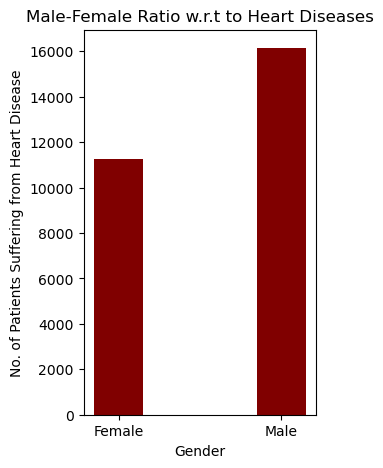

In [71]:
sql_st='''select Sex,count(*) from INFO,Disease where Disease.Disease = 'HeartDisease' and 
INFO.PatientID=Disease.PatientID group by Sex'''
mf=execute_sql_statement(sql_st,conn)
# Figure Size
fig = plt.figure(figsize =(3,5))
 
# Horizontal Bar Plot
g=[mf[0][0],mf[1][0]]
v=[mf[0][1],mf[1][1]]
plt.bar(g,v,width=0.3,color = 'maroon')
plt.xlabel("Gender")
plt.ylabel("No. of Patients Suffering from Heart Disease")
plt.title("Male-Female Ratio w.r.t to Heart Diseases")
plt.show()

## People of which AgeCategory are sufferring from Heart Disease?

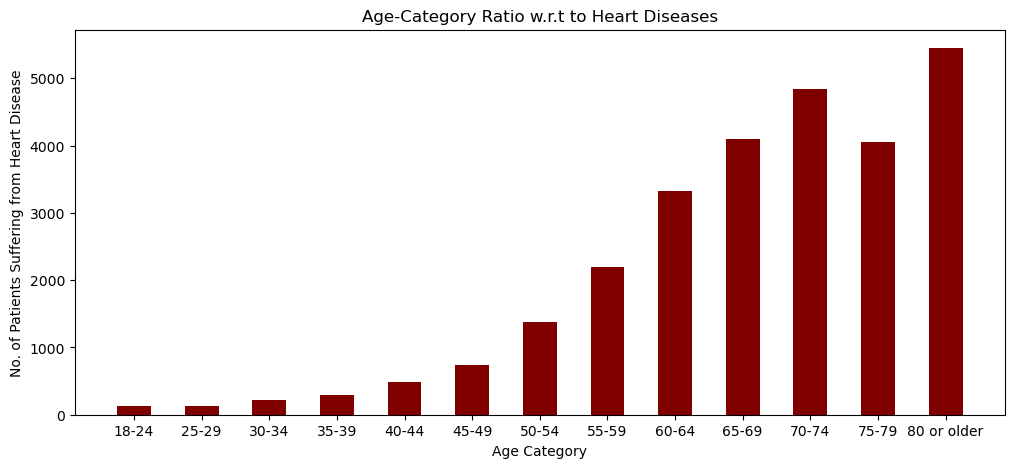

In [72]:
sql_st='''select AgeCategory,count(*) from INFO,Disease where Disease.Disease = 'HeartDisease' and 
INFO.PatientID=Disease.PatientID group by AgeCategory'''
ac=execute_sql_statement(sql_st,conn)
fig = plt.figure(figsize =(12,5))
labels = [i[0] for i in ac]
values = [i[1] for i in ac]
plt.bar(labels,values,width=0.5,color = 'maroon')
plt.xlabel("Age Category")
plt.ylabel("No. of Patients Suffering from Heart Disease")
plt.title("Age-Category Ratio w.r.t to Heart Diseases")
plt.show()

## People of which Race are suffering from Heart Disease compared to others?

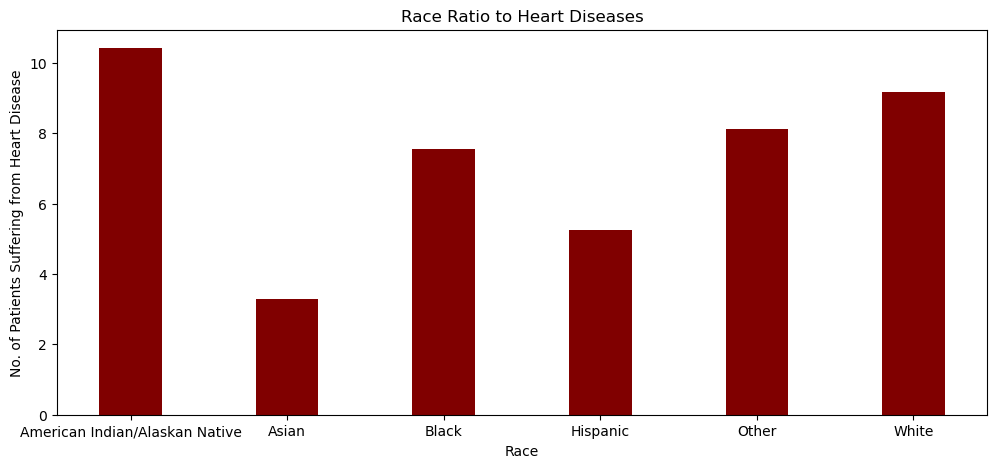

In [73]:
sql_st='''select Race,count(*) from INFO,Disease where Disease.Disease = 'HeartDisease' and 
INFO.PatientID=Disease.PatientID group by Race'''
race_cat = execute_sql_statement(sql_st,conn)
fig = plt.figure(figsize =(12,5))
race_dict={}
for i in race_cat:
    race_dict[i[0]]=i[1]
race_pop=dict(df['Race'].value_counts())
race_per={}
for i in race_dict:
    for j in race_pop:
        if i==j:
            race_per[i]=(race_dict[i]/race_pop[i])*100
labels = [i for i in race_per]
values_new = [v for k,v in race_per.items()]
plt.bar(labels,values_new,width=0.4, color = 'maroon')
plt.xlabel("Race")
plt.ylabel("No. of Patients Suffering from Heart Disease")
plt.title("Race Ratio to Heart Diseases")
plt.show()

## How many smokers and non-smokers in males and females are suffering from heart disease?

[('Female', 5880), ('Male', 10157)]


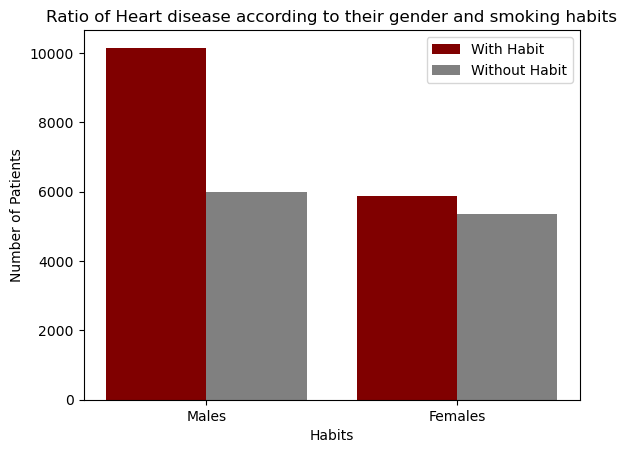

In [74]:
sql_st='''SELECT info.sex, count(*) from Habit INNER JOIN Disease on Disease.PatientID=Habit.PatientID 
inner join info on INFO.PatientID = Habit.PatientID where Disease='HeartDisease' and  Habit.Smoking="Yes"
group by info.sex'''
smo_hd_sex=execute_sql_statement(sql_st,conn)
print(smo_hd_sex)
sql_st='''SELECT info.sex, count(*) from Habit INNER JOIN Disease on Disease.PatientID=Habit.PatientID 
inner join info on INFO.PatientID = Habit.PatientID where Disease='HeartDisease' and  Habit.Smoking="No"
group by info.sex'''
non_smo_hd_sex = execute_sql_statement(sql_st,conn)

import numpy as np
X = ['Males','Females']
male_smokers = smo_hd_sex[1][1]
w_habits=[smo_hd_sex[1][1],smo_hd_sex[0][1]]
wo_habits=[non_smo_hd_sex[1][1],non_smo_hd_sex[0][1]]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, w_habits, 0.4, color = 'maroon', label = 'With Habit')
plt.bar(X_axis + 0.2, wo_habits, 0.4, color = 'gray', label = 'Without Habit')
  
plt.xticks(X_axis, X)
plt.xlabel("Habits")
plt.ylabel("Number of Patients")
plt.title("Ratio of Heart disease according to their gender and smoking habits")
plt.legend()
plt.show()

## How different habits like smoking, drinking and  physical activity may/may not affect heart disease condition in males and females?

In [75]:
sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.Smoking="Yes"'''
smo_hd=execute_sql_statement(sql_st,conn)[0][0]
sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.Smoking="No" '''
non_smo_hd = execute_sql_statement(sql_st,conn)[0][0]

sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.AlcoholDrinking="Yes" '''
ad_hd=execute_sql_statement(sql_st,conn)[0][0]
sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.AlcoholDrinking="No" '''
non_ad_hd=execute_sql_statement(sql_st,conn)[0][0]

sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.PhysicalActivity="Yes" '''
pa_hd=execute_sql_statement(sql_st,conn)[0][0]
sql_st='''SELECT count(*) from Habit  INNER JOIN Disease on Disease.PatientID=Habit.PatientID where 
Disease='HeartDisease' and  Habit.PhysicalActivity="No" '''
non_pa_hd=execute_sql_statement(sql_st,conn)[0][0]

smoke=[smo_hd,non_smo_hd]
alcohol=[ad_hd,non_ad_hd]
phyact=[pa_hd,non_pa_hd]



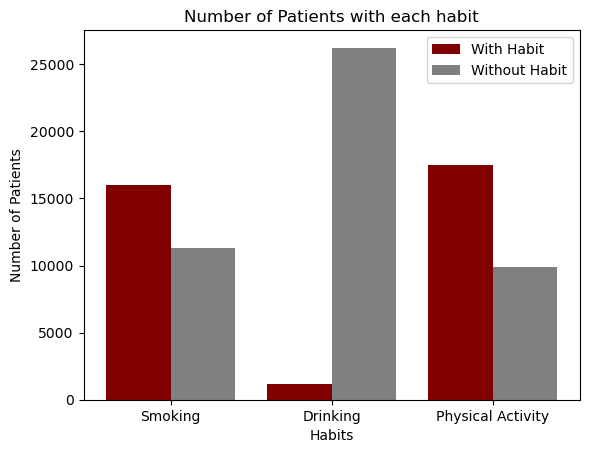

In [76]:
import numpy as np
X = ['Smoking','Drinking','Physical Activity']
w_habits=[smo_hd,ad_hd,pa_hd]
wo_habits=[non_smo_hd,non_ad_hd,non_pa_hd]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, w_habits, 0.4, color = 'maroon', label = 'With Habit')
plt.bar(X_axis + 0.2, wo_habits, 0.4, color = 'gray', label = 'Without Habit')
  
plt.xticks(X_axis, X)
plt.xlabel("Habits")
plt.ylabel("Number of Patients")
plt.title("Number of Patients with each habit")
plt.legend()
plt.show()

## People with what BMI are having Heart Disease?

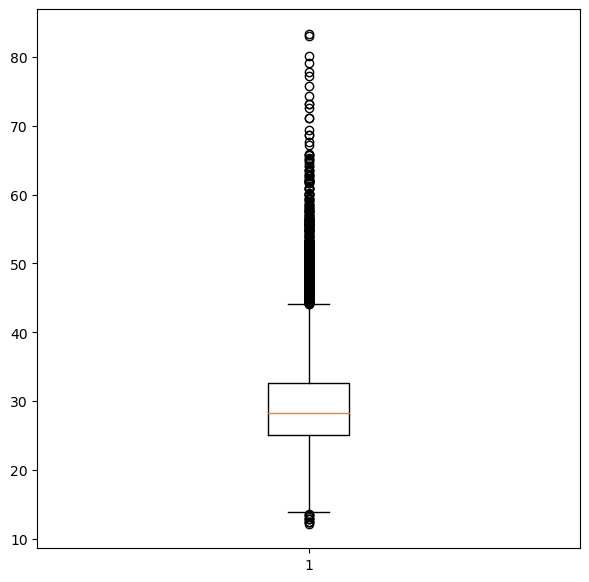

In [79]:
sql_st='''select BMI  from Health INNER JOIN Disease on Disease.PatientID=Health.PatientID 
where disease='HeartDisease' '''

bmi=execute_sql_statement(sql_st,conn)
bmi=[i[0] for i in bmi]

x=bmi
fig = plt.figure(figsize =(7,7))
 
# Creating plot
plt.boxplot(x)
 
# show plot
plt.show()

## How many Patients with Stroke Condition have Heart Disease too?

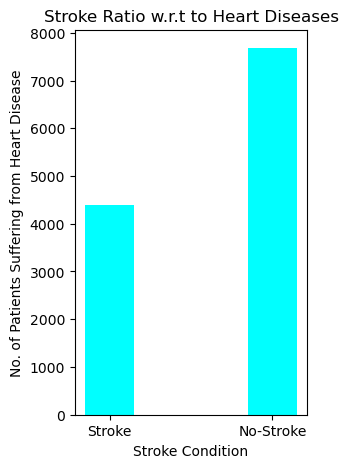

In [80]:
sql_st='''with A as(select PatientID from Disease where Disease='HeartDisease'),
B as(select PatientID from Disease where Disease='Stroke')
select count(*) from A,B where A.PatientID=B.PatientID'''

stroke_hd=execute_sql_statement(sql_st,conn)[0][0]

# Figure Size
fig = plt.figure(figsize =(3,5))


plt.bar(['Stroke','No-Stroke'],[stroke_hd,7680],width=0.3,color = 'cyan')
plt.xlabel("Stroke Condition")
plt.ylabel("No. of Patients Suffering from Heart Disease")
plt.title("Stroke Ratio w.r.t to Heart Diseases")
plt.show()


## People with what physical health(0-30) are having Heart Disease

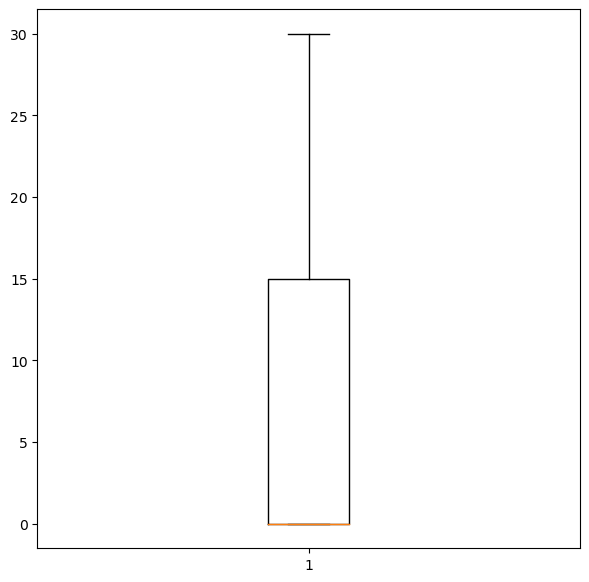

In [89]:
sql_st='''select PhysicalHealth from Health inner join disease on 
Health.PatientID=Disease.PatientID where disease='HeartDisease' '''

ph=execute_sql_statement(sql_st,conn)
ph=[i[0] for i in ph]
x=ph
fig = plt.figure(figsize =(7,7))
 
# Creating plot
plt.boxplot(x)
# show plot
plt.show()

## People with what mental health(0-30) are having Heart Disease

In [92]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

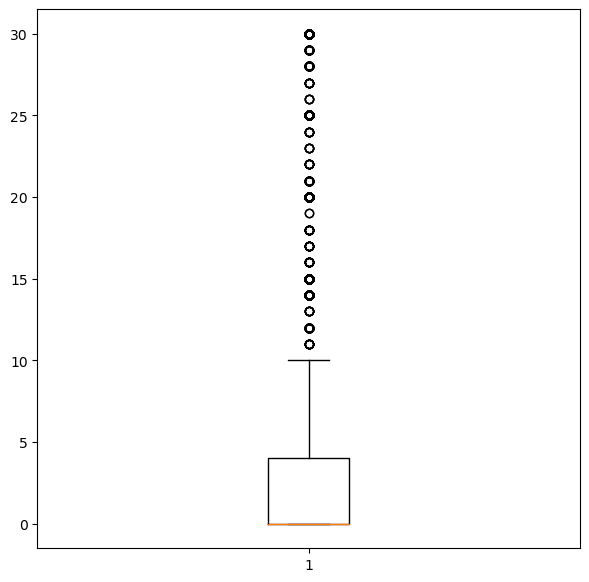

In [91]:
sql_st='''select MentalHealth from Health inner join disease on 
Health.PatientID=Disease.PatientID where disease='HeartDisease' '''

mh=execute_sql_statement(sql_st,conn)
mh
mh=[i[0] for i in mh]
x=mh
fig = plt.figure(figsize =(7,7))
 
# Creating plot
plt.boxplot(x)
# show plot
plt.show()

## How many People with skin cancer and Kidney Disease have Heart Disease?

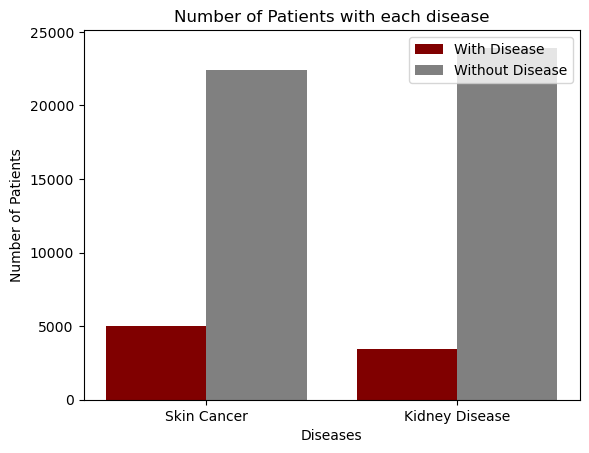

In [104]:
sql_st='''with A as(select PatientID from Disease where Disease='HeartDisease'),
B as(select PatientID from Disease where Disease='SkinCancer')
select count(*) from A,B where A.PatientID=B.PatientID'''
sc_hd=execute_sql_statement(sql_st,conn)[0][0]
sql_st='''with A as(select PatientID from Disease where Disease='HeartDisease'),
B as(select PatientID from Disease where Disease='KidneyDisease')
select count(*) from A,B where A.PatientID=B.PatientID'''
kd_hd = execute_sql_statement(sql_st,conn)[0][0]

X = ['Skin Cancer','Kidney Disease']
w_disease = [sc_hd, kd_hd]
wo_disease = [22393, 23918]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, w_disease, 0.4, color = 'maroon', label = 'With Disease')
plt.bar(X_axis + 0.2, wo_disease, 0.4, color = 'gray', label = 'Without Disease')
  
plt.xticks(X_axis, X)
plt.xlabel("Diseases")
plt.ylabel("Number of Patients")
plt.title("Number of Patients with each disease")
plt.legend()
plt.show()


In [116]:
from sklearn import preprocessing
from numpy import *
le = preprocessing.LabelEncoder()
cols=['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke',
        'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth',
       'Asthma', 'KidneyDisease', 'SkinCancer']
for col in cols:
    df[col]=le.fit_transform(df[col])

In [117]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,3,0,1,4,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,5,3,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,1,3,0,0,2,12.0,0,0,0


<AxesSubplot:>

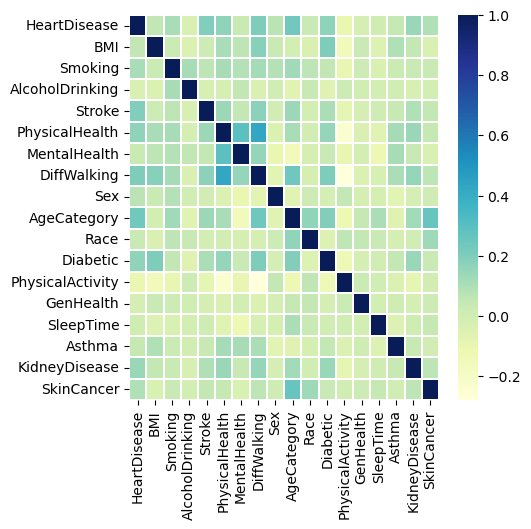

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = df.corr()
  
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [119]:
c=df.corr()['HeartDisease']
c=c[1:]
c

BMI                 0.051803
Smoking             0.107764
AlcoholDrinking    -0.032080
Stroke              0.196835
PhysicalHealth      0.170721
MentalHealth        0.028591
DiffWalking         0.201258
Sex                 0.070040
AgeCategory         0.233432
Race                0.034854
Diabetic            0.168553
PhysicalActivity   -0.100030
GenHealth          -0.011062
SleepTime           0.008327
Asthma              0.041444
KidneyDisease       0.145197
SkinCancer          0.093317
Name: HeartDisease, dtype: float64

<BarContainer object of 17 artists>

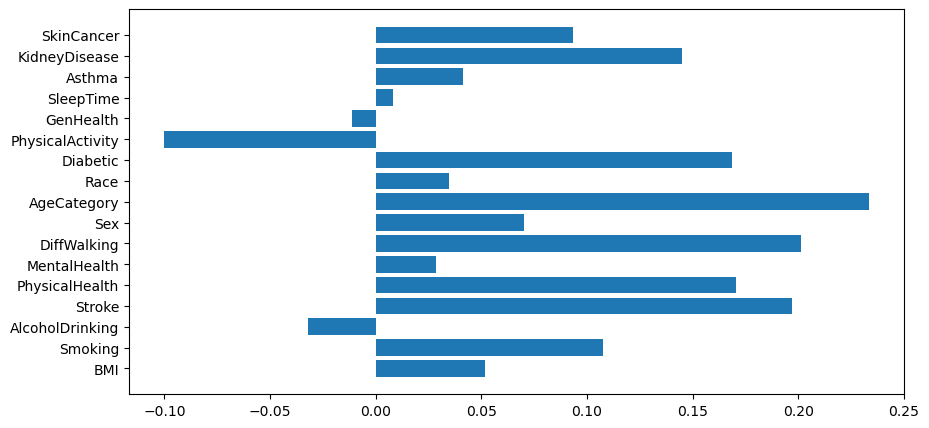

In [120]:
# Figure Size
fig = plt.figure(figsize =(10,5))
 
# Horizontal Bar Plot
plt.barh(df.columns[1:],c)

In [121]:
X=df.iloc[:,1:]
X

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0
319791,29.84,1,0,0,0.0,0.0,0,1,3,3,0,1,4,5.0,1,0,0
319792,24.24,0,0,0,0.0,0.0,0,0,5,3,0,1,2,6.0,0,0,0
319793,32.81,0,0,0,0.0,0.0,0,0,1,3,0,0,2,12.0,0,0,0


In [122]:
Y=df['HeartDisease']
Y

0         0
1         0
2         0
3         0
4         0
         ..
319790    1
319791    0
319792    0
319793    0
319794    0
Name: HeartDisease, Length: 319795, dtype: int64

In [138]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=True)

In [139]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [140]:
y_pred=rf.predict(X_test)

In [141]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.9056882681246624


In [142]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [144]:
df['HeartDisease'].value_counts()

0    292422
1     27373
Name: HeartDisease, dtype: int64

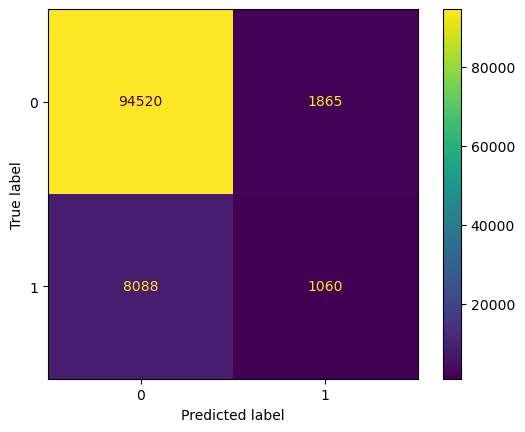

In [143]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()